In [66]:
from functools import partial
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [67]:
images_dir = './images'
masks_dir = './masks'
dirname, _, filenames = next(os.walk(images_dir))
print(filenames)

['image_15.png', 'image_22 copy.png', 'image_23 copy.png', 'image_5 copy 2.png', 'image_14.png', 'image_23 copy 2.png', 'image_14 copy 2.png', 'image_16.png', 'image_19 copy 2.png', 'image_16 copy.png', 'image_17 copy.png', 'image_8 copy 2.png', 'image_17.png', 'image_13.png', 'image_12.png', 'image_10.png', 'image_1 copy.png', 'image_11 copy 2.png', 'image_11.png', 'image_7 copy 2.png', 'image_16 copy 2.png', 'image_21 copy 2.png', 'image_6 copy.png', 'image_8.png', 'image_7 copy.png', 'image_9.png', 'image_25 copy.png', 'image_24 copy.png', 'image_2 copy 2.png', 'image_24 copy 2.png', 'image_13 copy 2.png', 'image_11 copy.png', 'image_10 copy.png', 'image_2.png', 'image_2 copy.png', 'image_3 copy.png', 'image_3.png', 'image_1.png', 'image_8 copy.png', 'image_9 copy.png', 'image_1 copy 2.png', 'image_10 copy 2.png', 'image_4.png', 'image_4 copy 2.png', 'image_22 copy 2.png', 'image_15 copy.png', 'image_15 copy 2.png', 'image_14 copy.png', 'image_5.png', 'image_7.png', 'image_21 copy.p

In [68]:
@tf.function
def load_img_with_mask(imagepath, images_dir: str = './images', masks_dir: str = './masks',images_extension: str = 'png', masks_extension: str = 'png') -> dict:
    image = tf.io.read_file(imagepath)
    image = tf.image.decode_jpeg(image, channels=3)
    print(imagepath)
    mask_filename = tf.strings.regex_replace(imagepath, images_dir, masks_dir)

    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels=1, expand_animations = False)
    return (image, mask)

@tf.function
def load_test_image(image_path, images_dir: str = "images", image_extension : str = 'png'):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    return image


# 2. Exploratory data analysis

['image_15.png', 'image_22 copy.png', 'image_23 copy.png']
./images/image_15.png
./images/image_22 copy.png
./images/image_23 copy.png


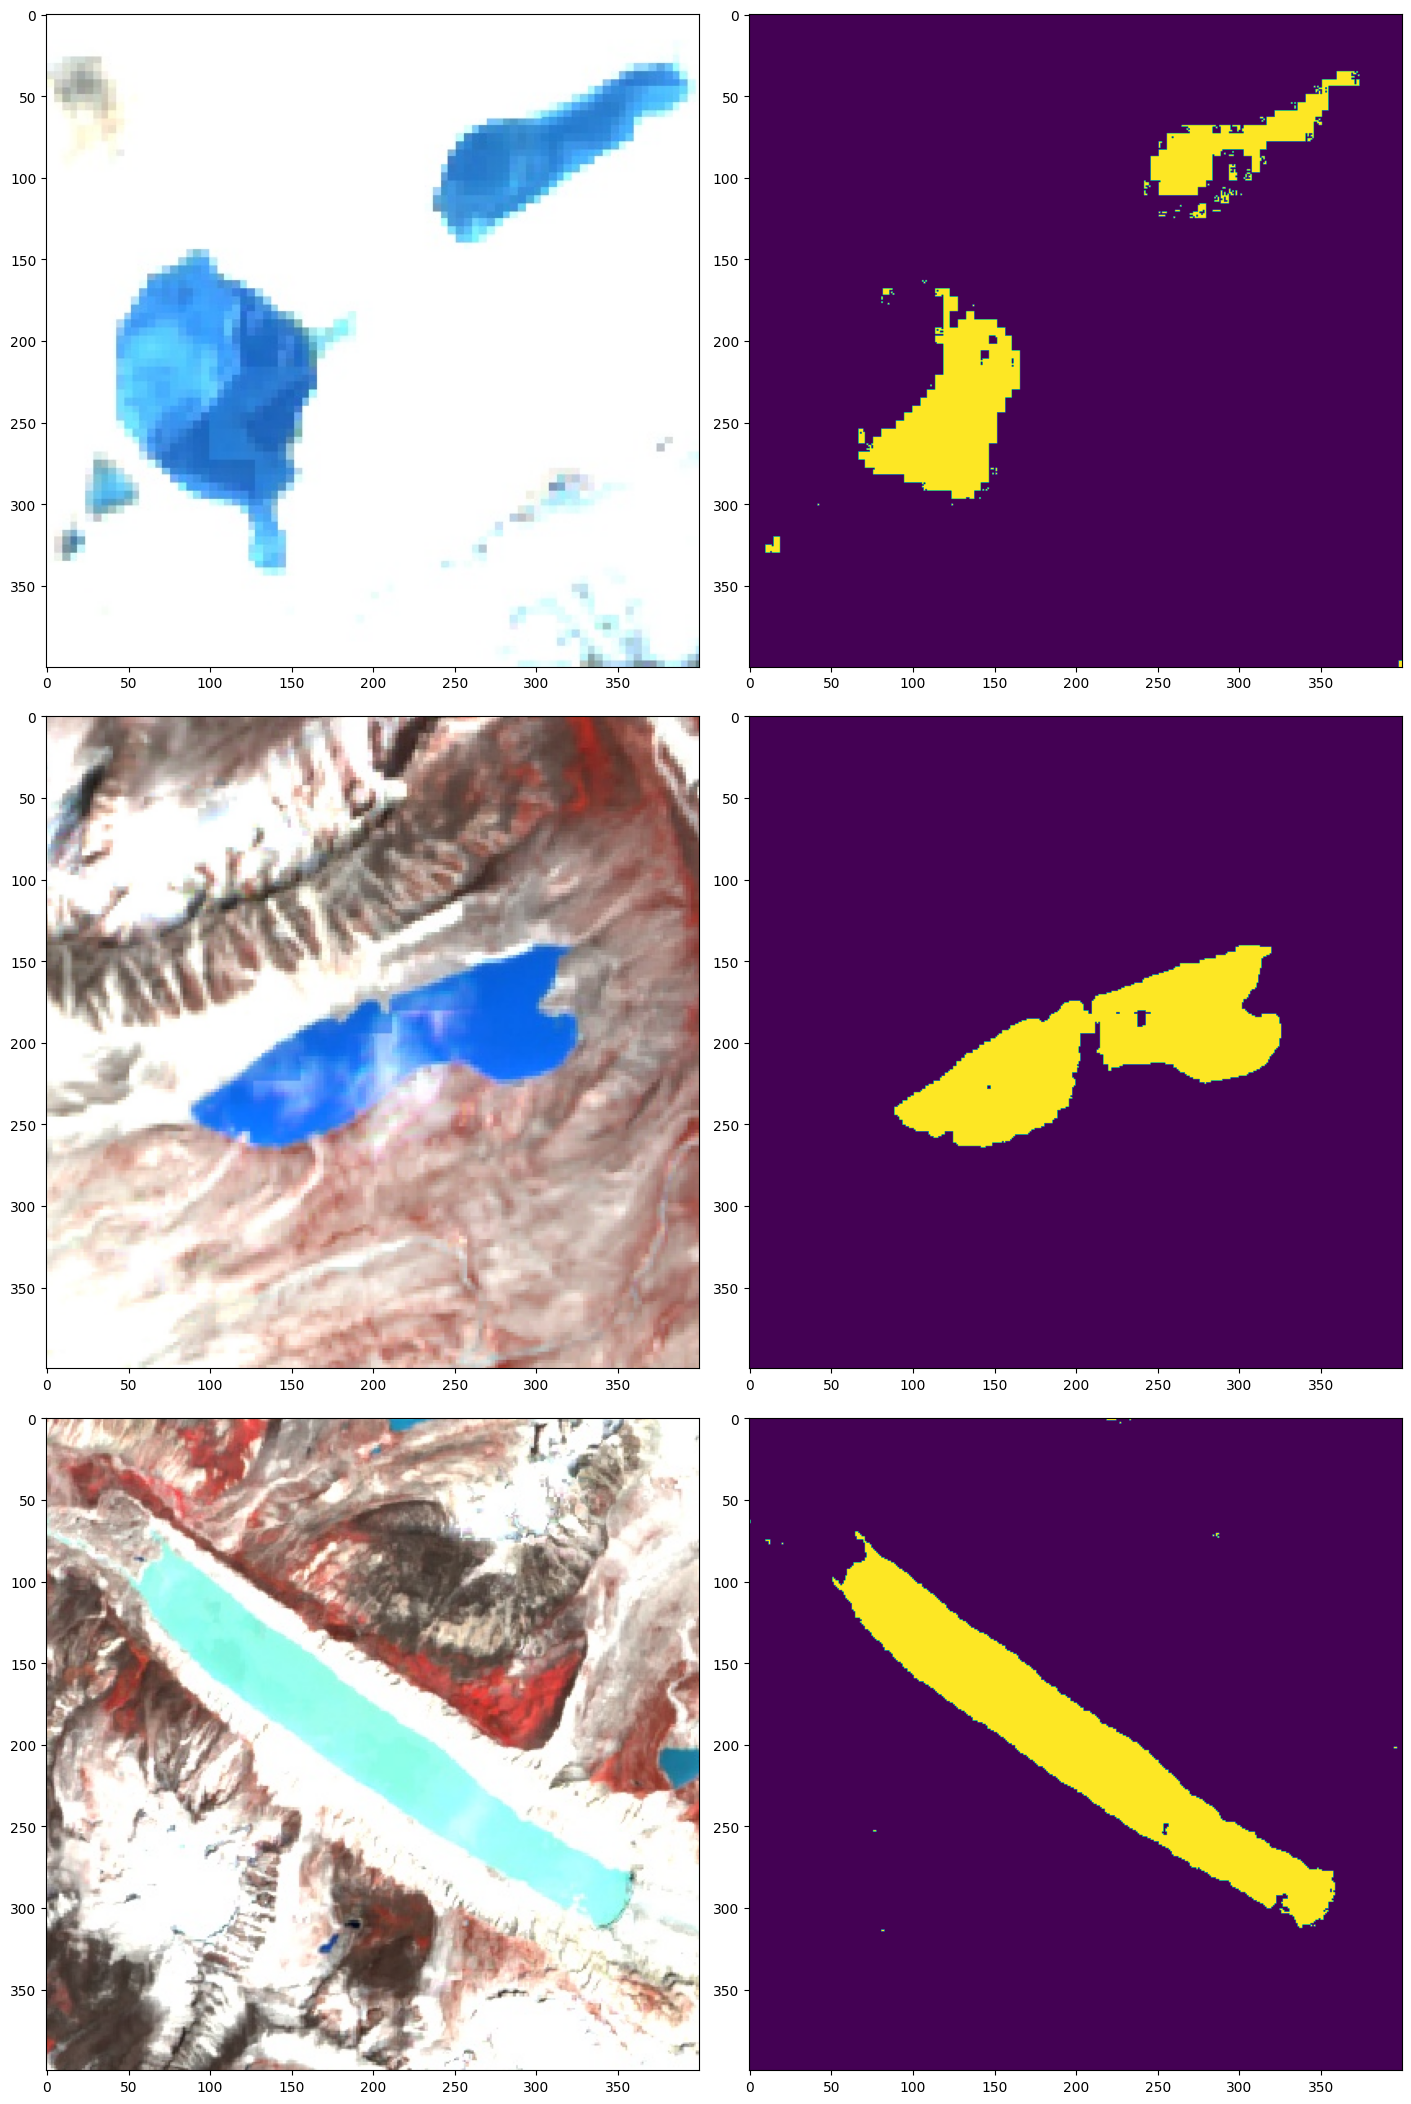

In [69]:
%matplotlib inline
n_examples = 3
print(filenames[:n_examples])
examples = [load_img_with_mask(os.path.join(images_dir, filenames[i])) for i in range(n_examples)]

fig, axs = plt.subplots(n_examples, 2, figsize=(14, n_examples*7), constrained_layout=True)
for ax, (image, mask) in zip(axs, examples):
    ax[0].imshow(image)
    ax[1].imshow(mask)
    

Some images seem to be rotated, it seems worth exploring if the original pictures are in the dataset. If that's the case then testing would be probably spoiled. Additionally in some of these images parts padded during this rotation are marked as water bodies and in some they are not. It may be a good idea to transform the images to get rid of this contradicting ground truths.

''

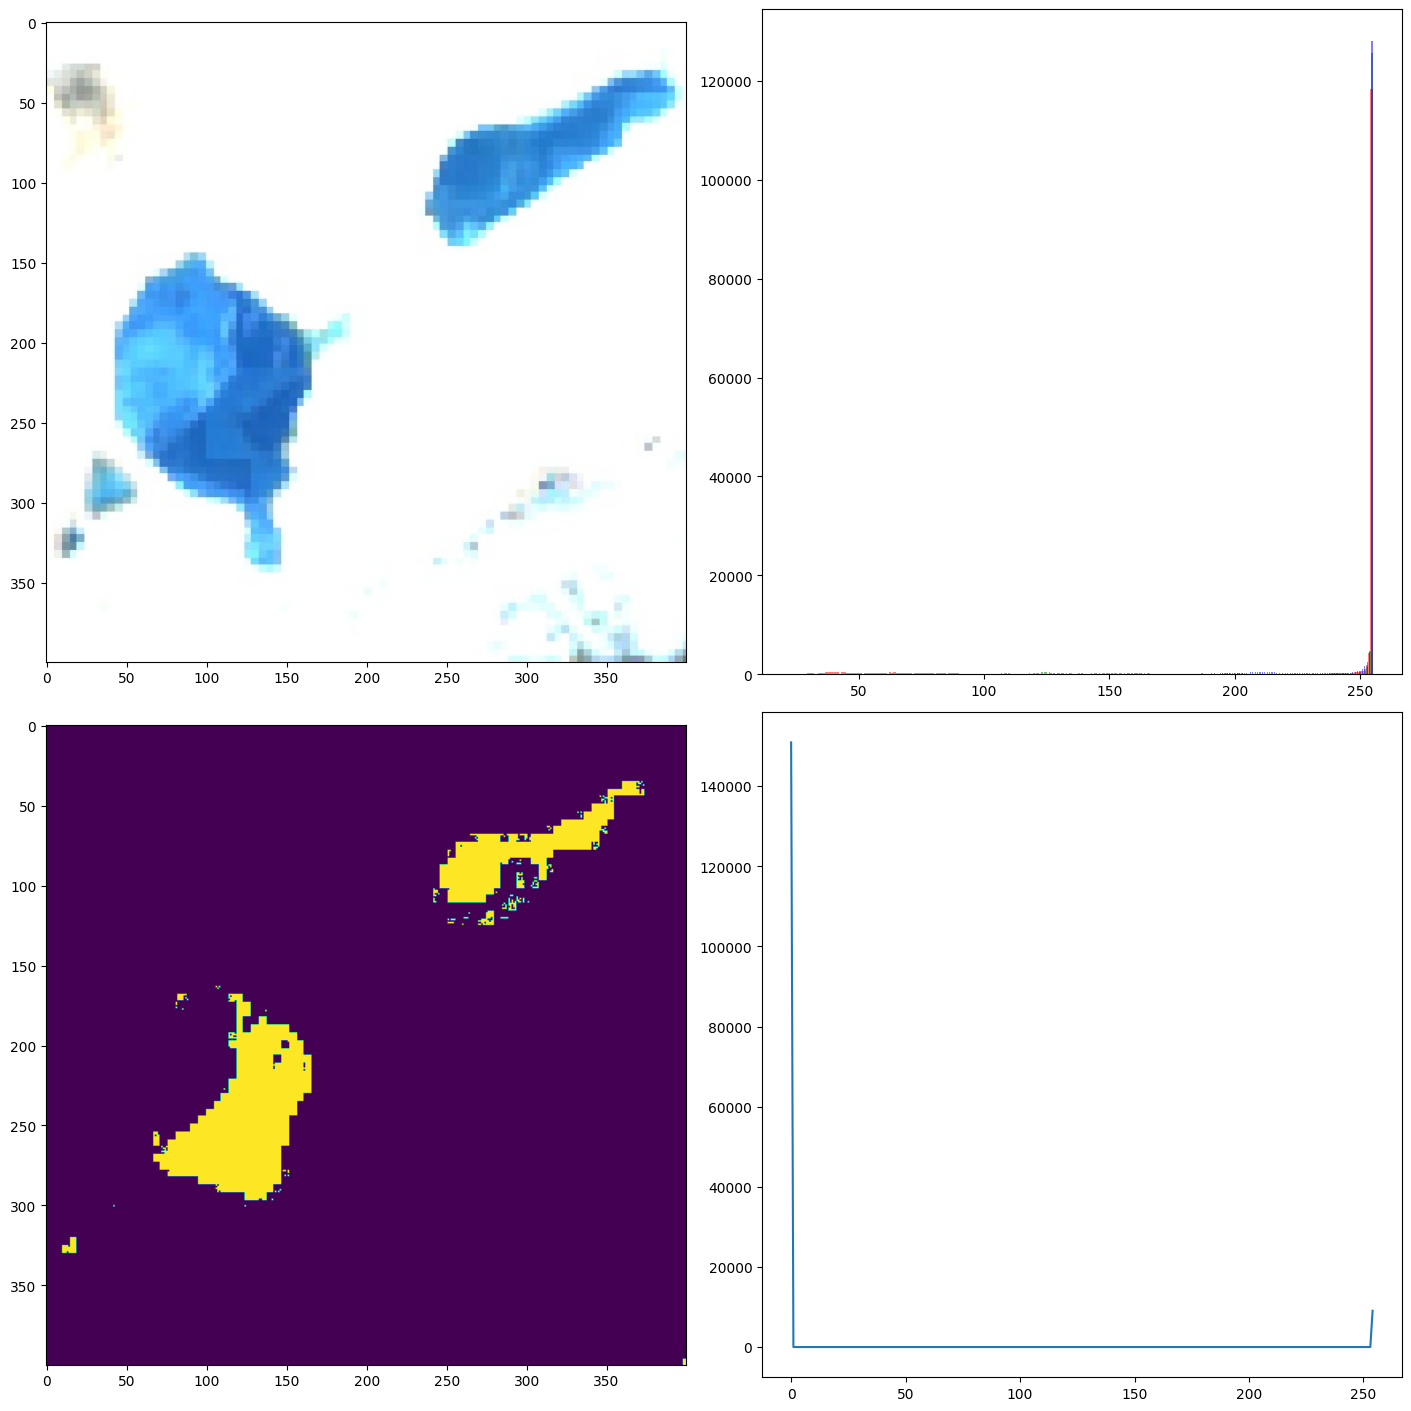

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14), constrained_layout=True)
example_image, example_mask = examples[0]
example_image = np.array(example_image)
example_mask = np.squeeze(example_mask)
axs[0][0].imshow(example_image)
axs[0][1].hist(example_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
axs[0][1].hist(example_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)

axs[1][0].imshow(example_mask)
histogram, bin_edges = np.histogram(example_mask, bins=256)
axs[1][1].plot(bin_edges[0:-1], histogram)
;

* For the main images there is a lot of values around 0, probably mainly because of the rotation. Values are centered around the middle, it may be a good idea to improve the contrast, maybe using histsogram equalization.
* Mask were stored in jpeg format, so there are no 2 discrete values, we should separate them using some threshold in the middle

# 3. Preprocessing the data

I will use tf.data.Dataset as it's quite easy to fetch the data and apply transformations utilizing optimized tf functions and prefetching.
There are a couple of transformation functions necessary before training our model:
* resize_images: some images wouldn't fit in the memory due to enormous size differences, with some of them having over 3000 in height or width. Only training images over some size threshold are rescaled.
*  convert_masks: splitting masks into 2 discrete values after they were encoded in jpeg
*  scale_values: Dividing images (not masks) to the range [0, 1]  makes the model converge faster
*  pad_images: Due to the specificity of the the used neural net: additional connections between nonconsecutive layers and the same size of input and output image the image sizes should be divisible by the number of downsamplings (taking into consideration the strides). Additionally as we accept arbitrary image sizes we shouldn't just pad to some predetermined values

In [71]:
@tf.function
def resize_images(images, masks, max_image_size=1500):
    shape = tf.shape(images)
    scale = (tf.reduce_max(shape) // max_image_size) + 1
    target_height, target_width = shape[-3] // scale, shape[-2] // scale
    images = tf.cast(images, tf.float32)
    masks = tf.cast(masks, tf.float32)
    if scale != 1:
        images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        masks = tf.image.resize(masks, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return (images, masks)

@tf.function
def resize_images_nn(images, max_image_size=1500):
    shape = tf.shape(images)
    scale = (tf.reduce_max(shape) // max_image_size) + 1
    target_height, target_width = shape[-3] // scale, shape[-2] // scale
    images = tf.cast(images, tf.float32)
    if scale != 1:
        images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return images
@tf.function
def scale_values(images, masks, mask_split_threshold = 128):
    images = tf.math.divide(images, 255)
    masks = tf.where(masks > mask_split_threshold, 1, 0)
    return (images, masks)

@tf.function
def scale_values_images(images):
    images = tf.math.divide(images, 255)
    return images

@tf.function
def pad_images(images, masks, pad_mul=16, offset=0):
    shape = tf.shape(images)
    height, width = shape[-3], shape[-2]
    target_height = height + tf.math.floormod(tf.math.negative(height), pad_mul)
    target_width = width + tf.math.floormod(tf.math.negative(width), pad_mul)
    images = tf.image.pad_to_bounding_box(images, offset, offset, target_height, target_width)
    masks = tf.cast(tf.image.pad_to_bounding_box(masks, offset, offset, target_height, target_width), tf.uint8)
    return (images, masks)

@tf.function
def pad_images_nn(images, pad_mul=16, offset=0):
    shape = tf.shape(images)
    height, width = shape[-3], shape[-2]
    target_height = height + tf.math.floormod(tf.math.negative(height), pad_mul)
    target_width = width + tf.math.floormod(tf.math.negative(width), pad_mul)
    images = tf.image.pad_to_bounding_box(images, offset, offset, target_height, target_width)
    return images

In [72]:
batch_size = 2
test_set_size = 20
validation_set_size = 5

dataset = tf.data.Dataset.list_files(images_dir + '/*.png')
print(dataset)
test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)
test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.map(scale_values)
test_dataset = test_dataset.shuffle(2)
test_dataset = test_dataset.map(lambda img, mask: resize_images(img, mask, max_image_size=2500))
test_dataset = test_dataset.map(pad_images)
test_dataset = test_dataset.batch(1).prefetch(1)

# testImages = tf.data.Dataset.list_files(testdir + "*.png", seed=42)
# testImages = testImages.map(load_test_image)
# testImages = testImages.map(scale_values_images)
# testImages = testImages.shuffle(20)
# testImages = testImages.map(lambda img: resize_images_nn(img, max_image_size=2500))
# testImages = testImages.map(pad_images_nn)
# testImages = testImages.batch(1).prefetch(5)

validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.map(scale_values)
validation_dataset = validation_dataset.shuffle(2)
validation_dataset = validation_dataset.map(resize_images)
validation_dataset = validation_dataset.map(pad_images)
validation_dataset = validation_dataset.batch(1).prefetch(1)

train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.map(scale_values)
train_dataset = train_dataset.shuffle(2)
train_dataset = train_dataset.map(resize_images)
train_dataset = train_dataset.map(pad_images)
train_dataset = train_dataset.batch(1).prefetch(1)



<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("imagepath:0", shape=(), dtype=string)


# 4. Creating the model

I decided to try training U-net model as it is performing very well in image segmentation task. My implementation has a lower number of channels due to memory restrictions. It also may be simple enough for binary classification.
Here is the image used in the original paper done by Olaf Ronneberger, Philipp Fischer and Thomas Brox:


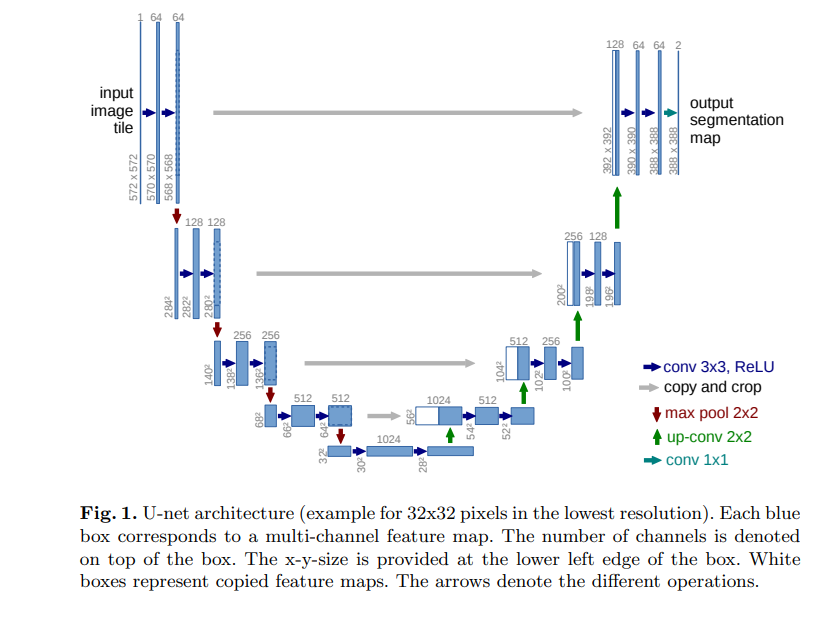

In [73]:
def get_unet(hidden_activation='relu', initializer='he_normal', output_activation='sigmoid'):
    PartialConv = partial(keras.layers.Conv2D,
     activation=hidden_activation,
     kernel_initializer=initializer,      
     padding='same')
    
    # Encoder
    model_input = keras.layers.Input(shape=(None, None, 3))
    enc_cov_1 = PartialConv(32, 3)(model_input)
    enc_cov_1 = PartialConv(32, 3)(enc_cov_1)
    enc_pool_1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_1)
    
    enc_cov_2 = PartialConv(64, 3)(enc_pool_1)
    enc_cov_2 = PartialConv(64, 3)(enc_cov_2)
    enc_pool_2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_2)
    
    enc_cov_3 = PartialConv(128, 3)(enc_pool_2)
    enc_cov_3 = PartialConv(128, 3)(enc_cov_3)
    enc_pool_3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_3)
    
    # Center
    center_cov = PartialConv(256, 3)(enc_pool_3)
    center_cov = PartialConv(256, 3)(center_cov)
    
    # Decoder
    upsampling1 = keras.layers.UpSampling2D(size=(2, 2))(center_cov)
    dec_up_conv_1 = PartialConv(128, 2)(upsampling1)
    dec_merged_1 = tf.keras.layers.Concatenate(axis=3)([enc_cov_3, dec_up_conv_1])
    dec_conv_1 = PartialConv(128, 3)(dec_merged_1)
    dec_conv_1 = PartialConv(128, 3)(dec_conv_1)
    
    upsampling2 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_1)
    dec_up_conv_2 = PartialConv(64, 2)(upsampling2)
    dec_merged_2 = tf.keras.layers.Concatenate(axis=3)([enc_cov_2, dec_up_conv_2])
    dec_conv_2 = PartialConv(64, 3)(dec_merged_2)
    dec_conv_2 = PartialConv(64, 3)(dec_conv_2)
    
    upsampling3 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_2)
    dec_up_conv_3 = PartialConv(32, 2)(upsampling3)
    dec_merged_3 = tf.keras.layers.Concatenate(axis=3)([enc_cov_1, dec_up_conv_3])
    dec_conv_3 = PartialConv(32, 3)(dec_merged_3)
    dec_conv_3 =  PartialConv(32, 3)(dec_conv_3)
    
    output = keras.layers.Conv2D(1, 1, activation=output_activation)(dec_conv_3)
    
    return tf.keras.Model(inputs=model_input, outputs=output)

In [74]:
model = get_unet()

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [75]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, None,      │        896 │ input_layer_4[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, None,      │      9,248 │ conv2d_72[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, None,      │          0 │ conv2d_73[0][0]   │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, None,      │     18,496 │ max_pooling2d_12… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_74[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, None,      │          0 │ conv2d_75[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, None,      │     73,856 │ max_pooling2d_13… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, None,      │    147,584 │ conv2d_76[0][0]   │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, None,      │          0 │ conv2d_77[0][0]   │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, None,      │    295,168 │ max_pooling2d_14… │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, None,      │    590,080 │ conv2d_78[0][0]   │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, None,      │          0 │ conv2d_79[0][0]   │
│ (UpSampling2D)      │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, None,      │    131,200 │ up_sampling2d_12… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, None,      │          0 │ conv2d_77[0][0],  │
│ (Concatenate)       │ None, 256)        │            │ conv2d_80[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, None,      │    295,040 │ concatenate_12[0… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, None,      │    147,584 │ conv2d_81[0][0] 

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

epochs = 1

print(train_dataset)
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping, lr_reduce])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 1), dtype=tf.uint8, name=None))>
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 547ms/step - loss: 0.3425 - val_loss: 0.1897 - learning_rate: 0.0010


# 5. Testing the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


NameError: name 'testImages' is not defined

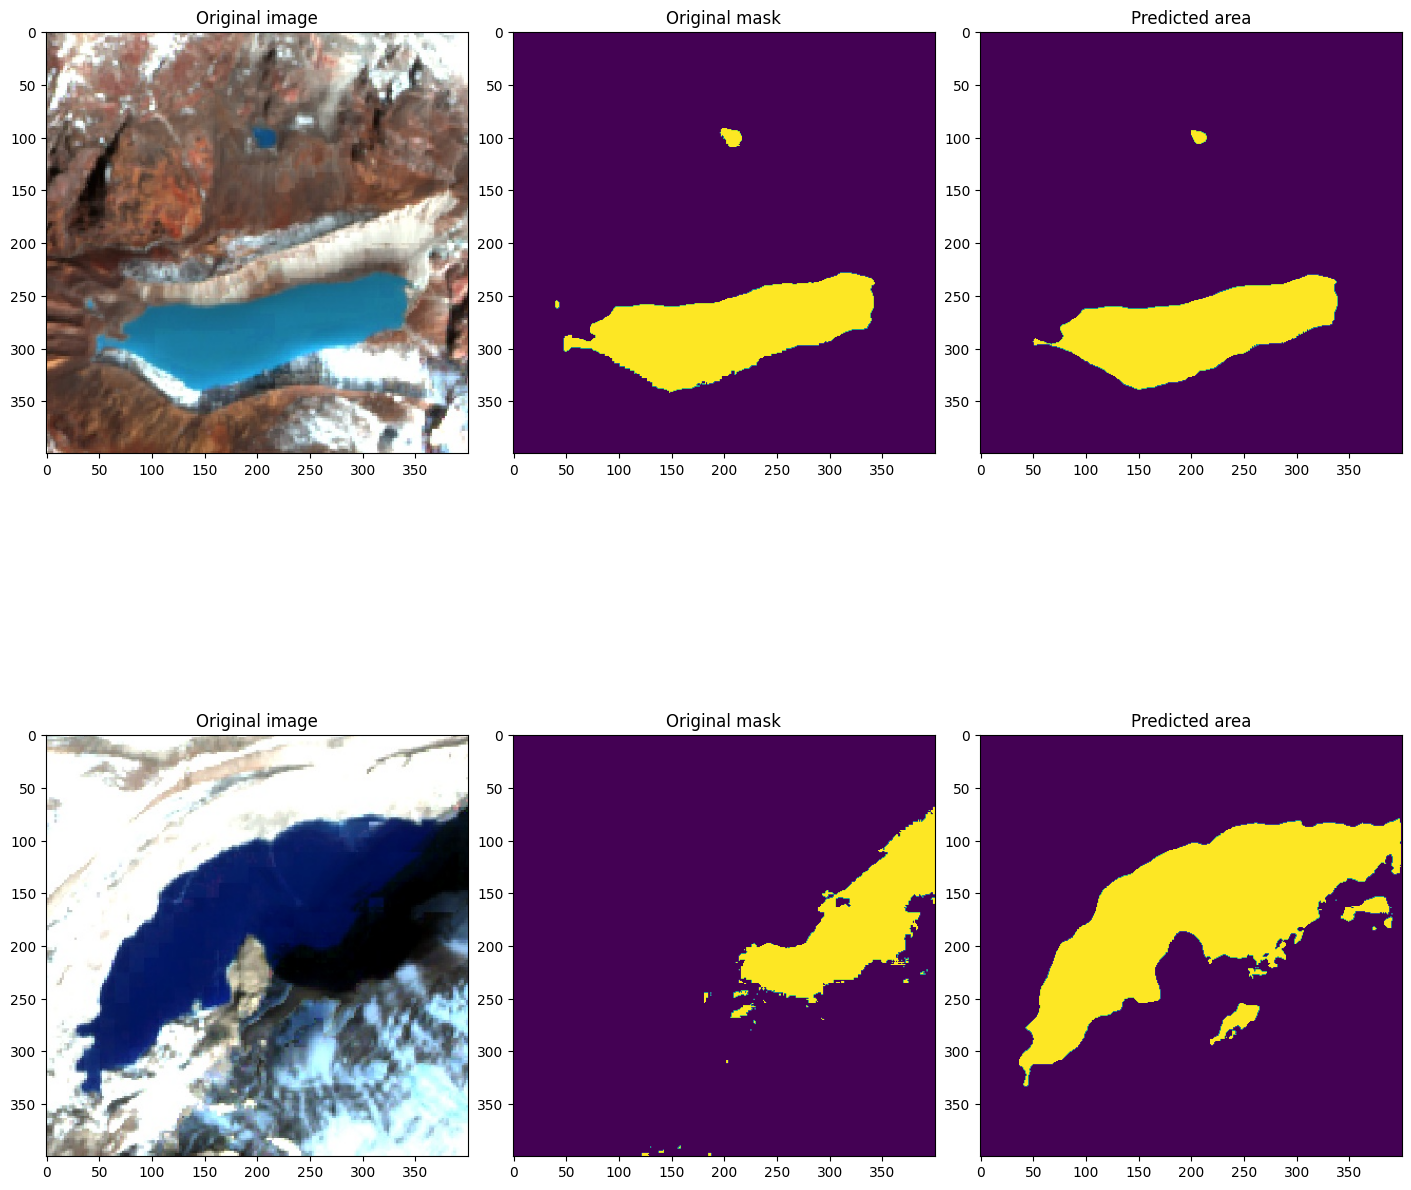

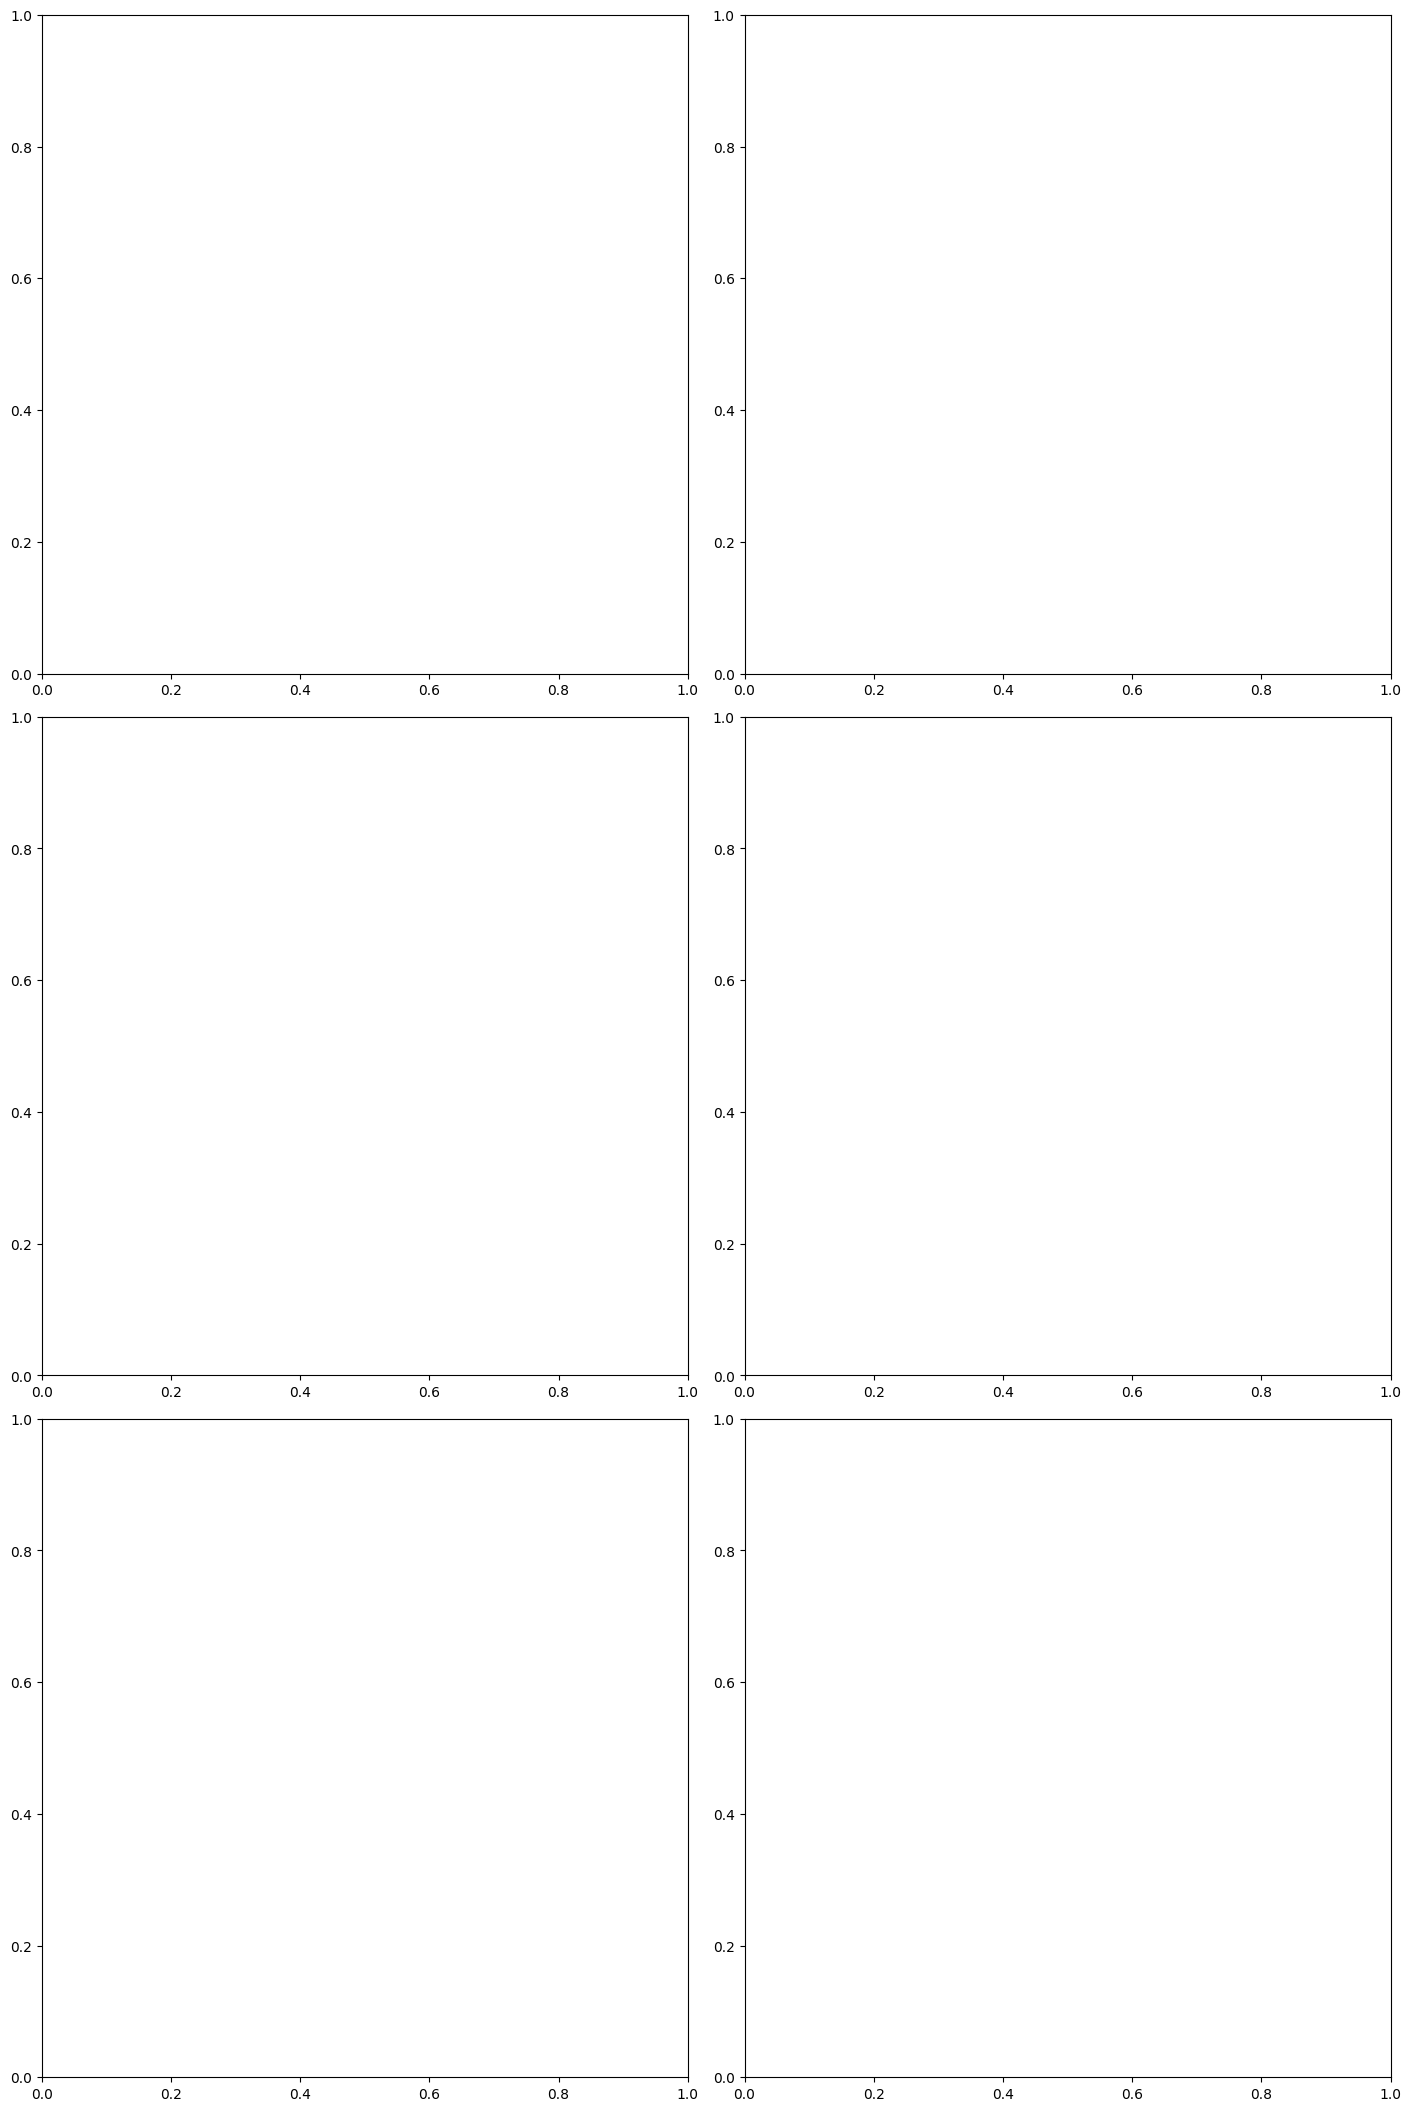

In [77]:
n_examples = 2

fig, axs = plt.subplots(n_examples, 3, figsize=(14, n_examples*7), constrained_layout=True)
for ax, ele in zip(axs, test_dataset.take(n_examples)):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 255, 0)
    ax[0].set_title('Original image')
    ax[0].imshow(image[0])
    ax[1].set_title('Original mask')
    ax[1].imshow(y_true[0])
    ax[2].set_title('Predicted area')
    ax[2].imshow(prediction)
    
n_examples = 3
fig, axs = plt.subplots(n_examples, 2, figsize=(14, n_examples*7), constrained_layout=True)
for ax, ele in zip(axs, testImages.take(n_examples)):
    image = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 255, 0)
    ax[0].set_title('Original image')
    ax[0].imshow(image[0])
    ax[1].set_title('Predicted area')
    ax[1].imshow(prediction)
    

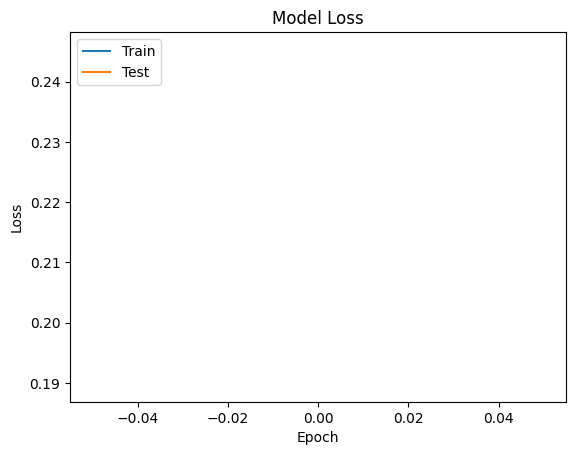

In [78]:
# plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [79]:
meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
for ele in test_dataset.take(test_set_size):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 1, 0)
    meanIoU.update_state(y_true[0], prediction)
print(meanIoU.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
0.74588287


2024-04-03 22:41:15.592091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



The results seem to be quite good for most of the pictures, but of course there is still a lot of room to improvement. Don't hesitate to comment and share your remarks!